# mini EPSCs

#### **Basic instructions:**
#### 1. **To run code cells**, you can either hit the play button to the left of the cell, or you can select the cell and **press shift-enter**.

#### 2. **The first time** you run this code notebook, you might get a popup asking to choose which version of Python to use (the python "kernel"). **Just hit enter** to choose the base/default version.

#### 3. Make sure you data (.abf) files are in the "data" folder here on the left. You can just copy/paste the files over from where they are saved on your computer.

In [19]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from utils import *
from single_channel_analysis import *
update_plot_defaults()

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [20]:
import sys
sys.path.append('../miniML/core/')
from miniML import MiniTrace, EventDetection
from miniML_plot_functions import miniML_plots

## 1. Choose the data file you want to analyze

#### Put the .abf files with your Ih recordings in the "data/HCN_channels" folder

In [21]:
data_folder = "data/miniEPSCs"

from glob import glob
data_files = glob(data_folder+"/*.abf")
print(data_folder)
data_files

data/miniEPSCs


['data/miniEPSCs\\25430003.abf',
 'data/miniEPSCs\\25501018.abf',
 'data/miniEPSCs\\25523016.abf',
 'data/miniEPSCs\\25523018.abf']

Choose which file you want to analyze and past the file name here:

In [22]:
data_file = 'data/miniEPSCs\\25430003.abf'

Now we can load the file and plot the raw data:

Trace callable attributes: ['data', 'sampling', 'sampling_rate', 'time_axis', 'total_time']
sampling rate: 25000.0 Hz


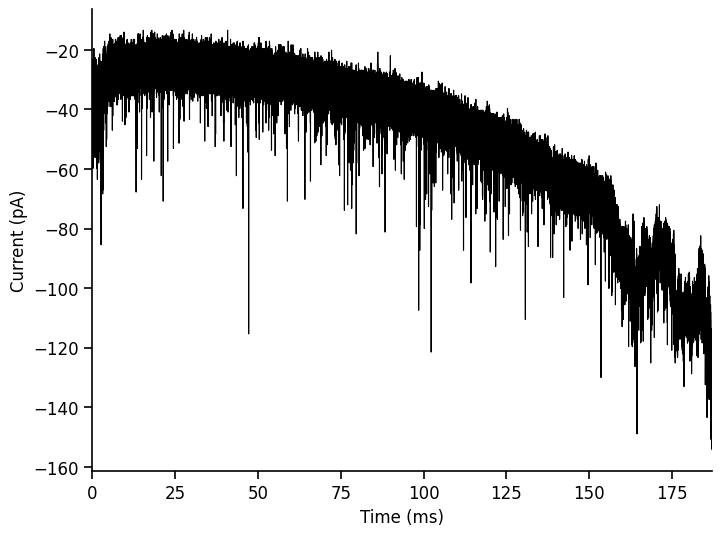

In [ ]:
current_traces = MiniTrace.from_axon_file(filename=data_file, channel=0, unit='pA')

import inspect
attributes = [name for name, value in inspect.getmembers(type(current_traces)) if isinstance(value, property)]
print(f"Trace callable attributes: {attributes}")
print(f"sampling rate: {current_traces.sampling_rate} Hz")

ax = plot_traces(current_traces.time_axis, current_traces.data)
# ax[0].set_ylim([-1000,200])
# ax[0].set_xlim([1.1,2.9])
plt.show()

## 2. Signal processing

Let's start by filtering the signal to get a stable baseline, remove some of the 50/60 Hz line noise, and smooth away some high-frequency noise.

The goal here is to only remove the noise with minimal distortion of the data.

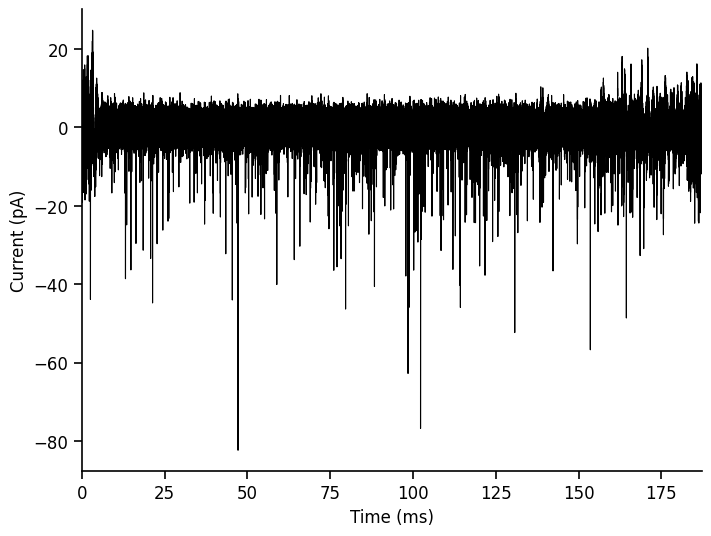

In [60]:
# Step 1: Detrend the data to remove linear or constant trends.
current_traces = current_traces.detrend(detrend_type='linear', num_segments=10)

# Step 2: Apply a highpass filter to remove low-frequency noise + lowpass to remove high-frequency noise
current_traces = current_traces.filter(
    line_freq=60,    # Frequency (Hz) of electrical noise to remove: 50 Hz (in Europe) or 60 Hz (in the US).
    width=2,         # Width (Hz) controls the width of frequency bands around the line frequency the filter cuts out.
    highpass=0.5,      # Removes low-frequency drift. Set a value in Hz (e.g. 1 for 1 Hz).
    lowpass=2000,    # Removes high-frequency noise. Set a value in Hz (e.g. 100 for 100 Hz).
    order=4)         # Controls sharpness of the filter. Higher = sharper cutoff.


ax = plot_traces(current_traces.time_axis, current_traces.data)
# ax[0].set_ylim([-1000,200])
# ax[0].set_xlim([1.1,2.9])
plt.show()

Cut out region of interest

Run miniEPSC detection algorithm

In [ ]:
win_size = 600
direction = 'negative'

detection = EventDetection(data=trace,
                           model_path='../miniML/models/GC_lstm_model.h5',
                           window_size=win_size,
                           model_threshold=0.5,
                           batch_size=512,
                           event_direction=direction,
                           compile_model=True,
                           verbose=2)

To detect events, we have to call the `detect_events()` method. Set the eval flag to **False** if you do not want to analyse the detected events. For the downstream analysis, four parameters can be adjusted:

- **peak_w**: int, default = 5. Determines the minimum width of peaks in the prediction trace.


- **rel_prom_cutoff**: float, default = 0.25. In case multiple peaks in the first derivative are found, this value determines the minimum prominence (relative to the largest prominence) a peak needs to have to be considered an event. For preparations that have no or little to no overlapping events, this value can be set to 1, to find only single peaks.


- **convolve_win**: int, default = 20. Size of the Hann window used to filter the data for detection of event location and event analysis.


- **gradient_convolve_win**: int, default = 2*convolve_win (40 here): Size of the Hann window used to filter the first derivative of the filtered data to determine event locations.


For other data than the one shown here, **convolve_win** and **gradient_convolve_win** are the most crucial to adjust. To check the filter settings, the `plot_gradient_search()` method (see "Inspect the results" section below) can be used.

In [ ]:
detection.detect_events(eval=True,
                        peak_w=5,
                        rel_prom_cutoff=0.25,
                        convolve_win=20,
                        gradient_convolve_win=40)

## Inspect the results

After the event detection and analysis, we can create some plots. MiniML includes several plotting methods that can be found in the *miniML_plots* class in `miniML_plot_functions.py`. A miniML *EventDetection* object has to be passed as data argument.


`plot_prediction()` shows the model inference trace, optinally together with the data and marked events. Note that we plot a filtered version of the trace in this example.

`plot_event_overlay()` creates a figure with all detected events overlaid, as well as their average and the exponential fit on the average.

`plot_event_histogram()` plots a histogram of event amplitudes (optional: inter-event-intervals). Set *cumulative=True* for a cumulative probability plot.

`plot_gradient_search()` plots the event location search. Top pannel contains the prediction, middle pannel the data and filtered data and lower panel the first derivative and filtered first derivative. Useful if the default filter settings (see above) are not appropriate for your data.


In [ ]:
MiniPlots = miniML_plots(data=detection)

In [ ]:
MiniPlots.plot_prediction(include_data=True, 
                          plot_filtered_prediction=True, 
                          plot_filtered_trace=True, 
                          plot_event_params=True)

In [ ]:
MiniPlots.plot_singular_event_average()

In [ ]:
MiniPlots.plot_event_overlay()

In [ ]:
MiniPlots.plot_event_histogram(plot='amplitude', # Options: 'frequency', 'amplitude'
                               cumulative=True)

In [ ]:
MiniPlots.plot_event_histogram(plot='frequency', # Options: 'frequency', 'amplitude'
                               cumulative=False)

In [ ]:
MiniPlots.plot_event_locations(plot_filtered=False)

In [ ]:
MiniPlots.plot_detection()

## Save results to file

Finally, we can save the results to file for later use. The `save_to_pickle()` method saves the data in pickle format (essentially a python dictionary). If desired, the mini trace and the generated prediction trace can be saved as well. Note that this will increase file size.

In [ ]:
detection.save_to_pickle(filename='../results/gc_mini_trace_results.pickle', 
                         include_prediction=False, 
                         include_data=False)

The `save_to_h5()` method saves the detected events and the individual event statistics to a specified HDF5 file. It also includes average results for amplitude, charge, frequency, etc.

In [ ]:
detection.save_to_h5(filename='../results/gc_mini_trace_results.h5')

In addition, results can be saved in a delimited text format using `save_to_csv()`. This methods takes a filename and saves two .csv files containing event population statistics and individual event statistics, respectively.

In [ ]:
detection.save_to_csv(filename='../results/gc_mini_trace_results.csv')


```{seealso}
Refer to the documentation in the `miniML.py` file for more details on the saving methods.
````